___

# Machine Learning in Geosciences ] 
Department of Applied Geoinformatics and Carthography, Charles University

Lukas Brodsky lukas.brodsky@natur.cuni.cz


## Deep Learning - Convolutional Neural Networks

Task: This notebook introduces CNN model with PyTorch https://pytorch.org on example of simulated images containing 3 shapes at random position. 
Architecture: Fully Connected Network (FCN) 

**Tasks**: 
    
    1. Develop full CNN workflow, including implementing the model and setting modelling parameters.  
    
    2. Change level of noise from 0.1 to 0.5 and 0.9 and evaluate learning.  
    

#### Architecture inspiration 

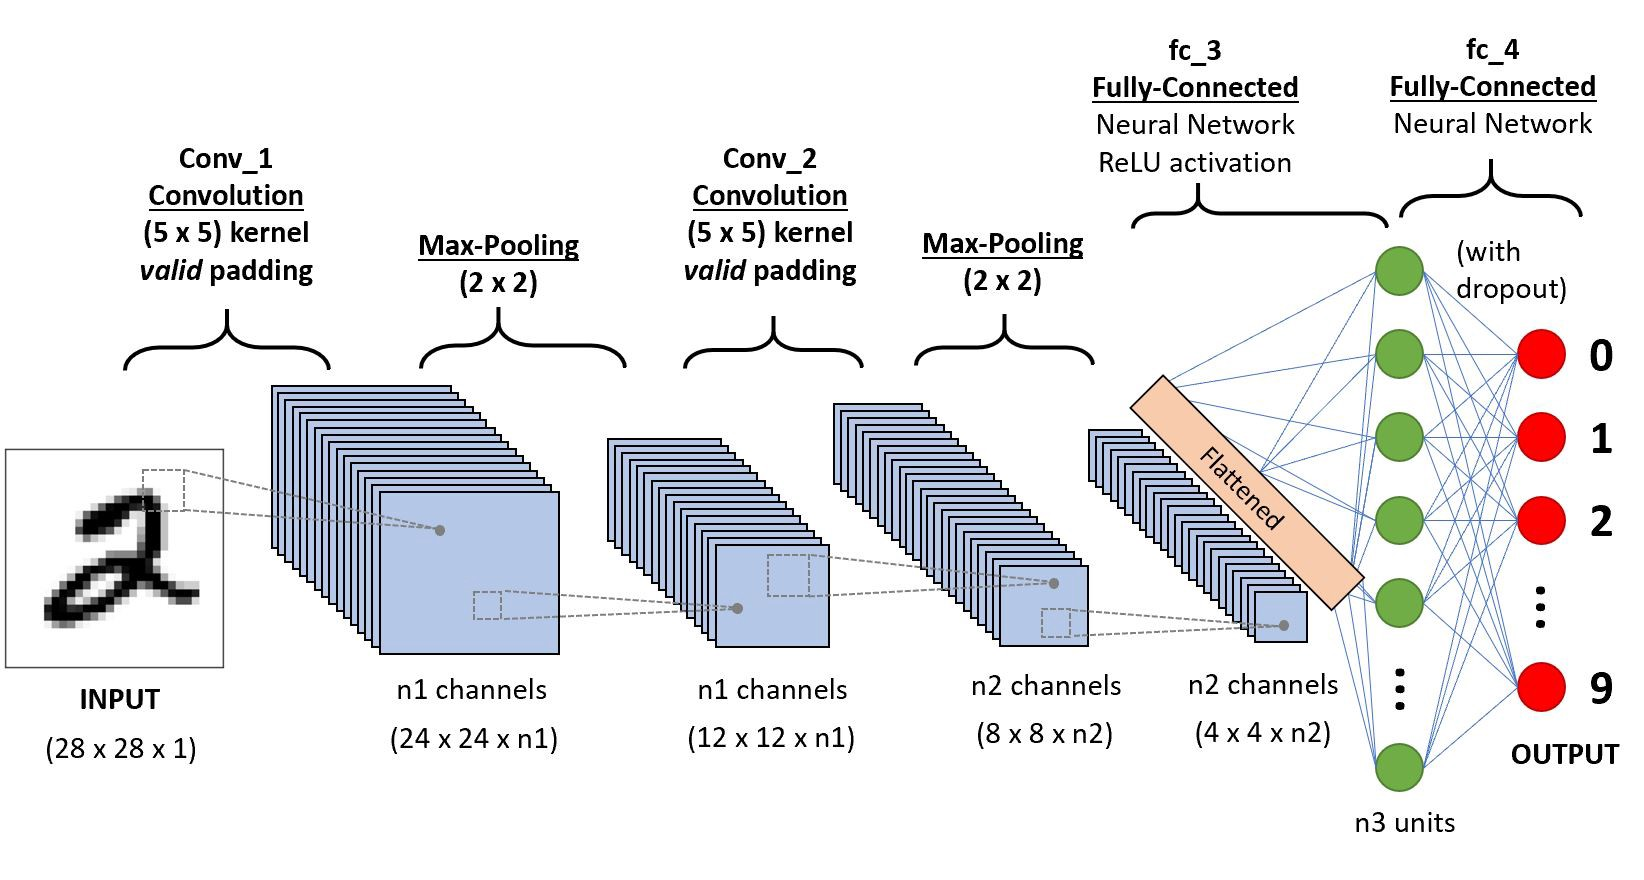

#### Main steps in the modelling workflow 
1. Load dataset
2. Make dataset iterable
3. Create model class
4. Instantiate model class
5. Instantiate loss class
6. Instantiate optimizer class
7. Train model

In [ ]:
import numpy as np
np.random.seed(42) 
import matplotlib.pyplot as plt
import time 

# PyTorch imports 
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.autograd import Variable

### Simulated data 

In [ ]:
# To simulate data
from simulate_images import generate_image_shapes

In [ ]:
# TEST the data 
height, width, count = 28, 28, 9
noise = 0.2
X, Y, y_label = generate_image_shapes(height, width, count, noise)

In [ ]:
# batch, channel, height, width 
X.shape

In [ ]:
y_label

In [ ]:
object_shapes = ['square',  'triangle', 'circle']  
# for label in y_label: 
#     print(f'label {label} = {object_shapes[label]}')

In [ ]:
np.unique(y_label)

In [ ]:
image_no=3
print(f'Label: {y_label[image_no]}')
plt.imshow(X[image_no][0,:,:])

In [ ]:
plt.figure(figsize=(10,10)) 
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i][0,:,:])

### Step 1. Load dataset

In [ ]:
# Helper class to generate simulated images, masks and labels 
# and getting an image when called   

class SimDataset(Dataset):
    def __init__(self, height, width, count, noise):
        self.input_images, self.target_masks, self.target_labels=generate_image_shapes(height, width, count, noise)

    def __len__(self):
        return len(self.input_images)

    # indexing operation on objects; enable instances of the class 
    # to use the indexing syntax to retrieve elements
    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        label= self.target_labels[idx] 

        return [image, mask, label]

### Step 2. Make dataset iterable

In [ ]:
def get_data_loaders(height, width, noise, train_size, test_size, batch_size=5):

    # simulated based on given parameters
    train_set = SimDataset(height, width, train_size, noise) 
    test_set = SimDataset(height, width, test_size, noise) 

    # convert to PyTorch dataloade r
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_dataloader, test_dataloader


In [ ]:
### Prepare data as dataloader (iterator)
batch_size = 20
height, width = 28, 28 
noise = 0.5 
train_dataloader, test_dataloader = get_data_loaders(height, width, noise, train_size=500, test_size=500, 
                                                     batch_size=batch_size)

### Step 3: Define Model 

### Model architecture: 

Logic: 
* Repeated Convolution -> ReLU -> Maxpooling 
* Flatten 
* Fully connected layer 
-- 

Main elements: 

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)` 
applies a 2D convolution over an input signal composed of several input planes.
In the simplest case, the output value of the layer with input size (N,Cin,H,W) and output (N,Cout,Hout,Wout). 


In [ ]:
# Con2d test 
# m = nn.Conv2d(pass)
input = torch.randn(9, 1, 28, 28)
# output 
pass 

`torch.nn.ReLU(inplace=False)`
applies the rectified linear unit function element-wise. 


In [ ]:
# ReLU test
# m = nn.ReLU()
input = torch.randn(2)
# output 
pass 

`torch.nn.MaxPool2d(kernel_size, stride=None, padding=0)` 
Applies a 2D max pooling over an input signal composed of several input planes.

In the simplest case, the output value of the layer with input size (N,C,H,W), output (N,C,Hout,Wout) and kernel_size (kH,kW). 
If padding is non-zero, then the input is implicitly padded with negative infinity on both sides for padding number of points. 


In [ ]:
# Test pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
input = torch.randn(20, 16, 50, 32)
# output
pass 

`torch.nn.Linear(in_features, out_features)` 
Applies a linear transformation to the incoming data: y=xAT+b.

This module supports TensorFloat32.

On certain  devices, when using float16 inputs this module will use different precision for backward.



        `in_features` (int) – size of each input sample

        `out_features` (int) – size of each output sample

        `bias` (bool) – If set to False, the layer will not learn an additive bias. Default: True



In [ ]:
# test Linear()
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
# output
# print(output.size())
pass 

### Flattening the 2D tensor 

`view` or `flatten`? 

First of all, .view() works only on contiguous data, while .flatten() works on both contiguous and non contiguous data. Functions like transpose whcih generates non-contiguous data, can be acted upon by .flatten() but not .view().

Coming to copying of data, both .view() and .flatten() does not copy data when it works on contiguous data. However, in case of non-contiguous data, .flatten() first copies data into contiguous memory and then change the dimensions. Any change in the new tensor would not affect th original tensor.

In [ ]:
base = torch.tensor([[0, 1],[2, 3]])
base.is_contiguous()

In [ ]:
t = base.transpose(0, 1)  # `t` is a view of `base`. No data movement happened here.
# View tensors might be non-contiguous.
t.is_contiguous()

In [ ]:
m = torch.linspace(1, 3 * 9, steps=3*9)
m = torch.reshape(m, (3, 1, 3, 3))
m

In [ ]:
m.size()

In [ ]:
m.view(-1)

In [ ]:
# but 3 instances in a batch 
m.view(m.size(0), -1)

### Model architecture 

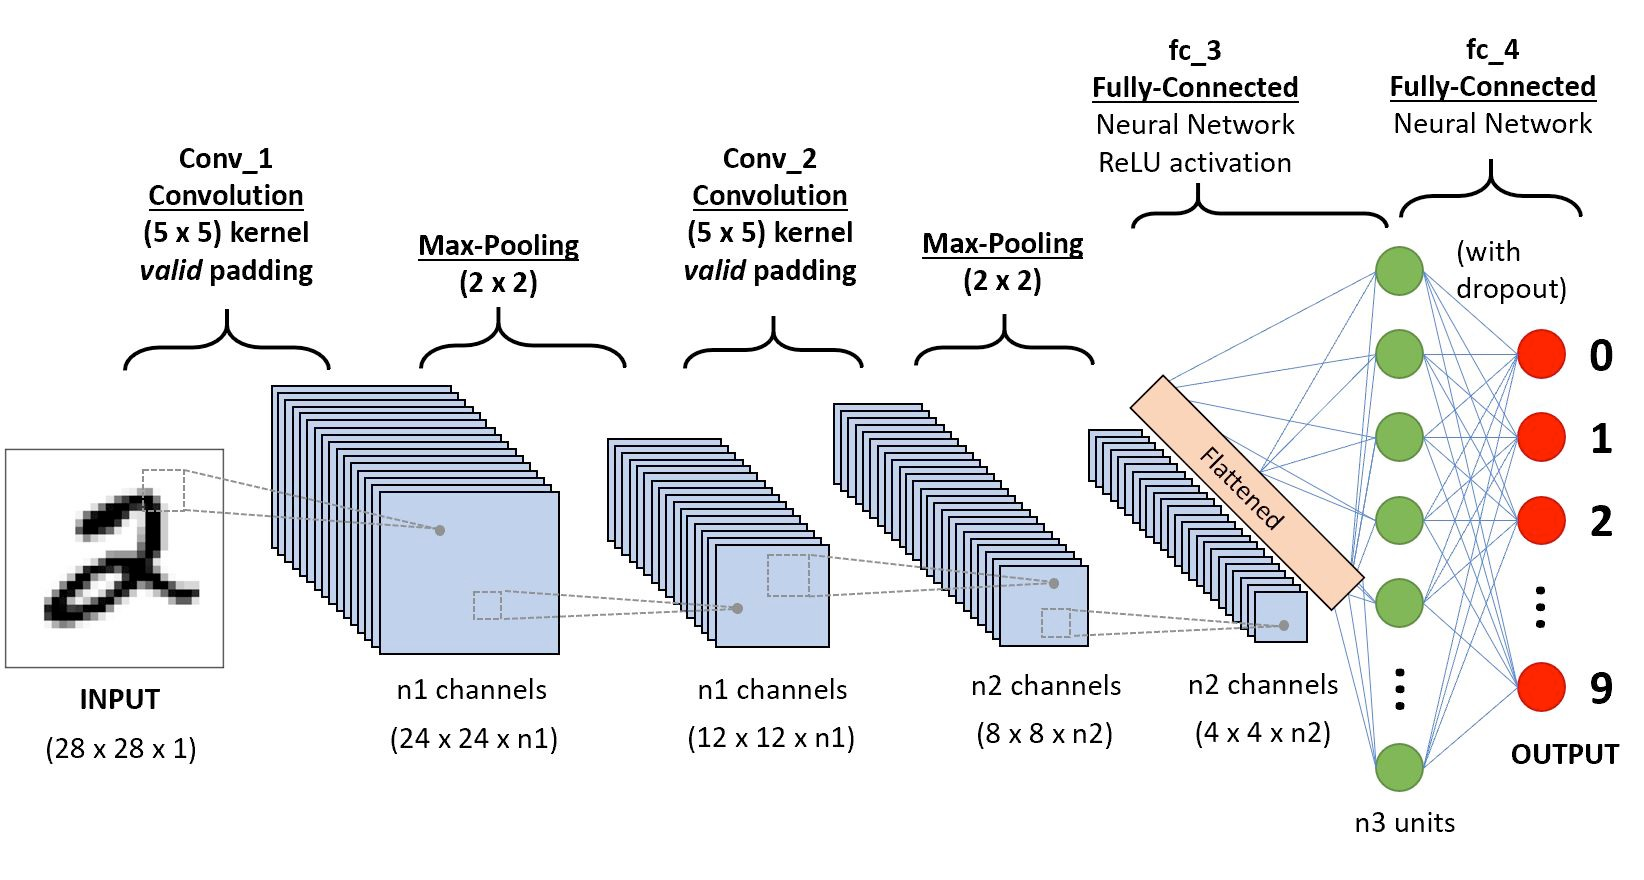

1. Conv(1, 16, 5, 1, 2), ReLU, MaxPool(2) 
2. Conv ... 
3. Flatten 
4. Fully connected - read out 


In [ ]:
# Test the elements of the full network first! 
pass 

In [ ]:
# CNN Model 

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        pass         


    def forward(self, x):

        pass 

        return out


### Step 4: Instantiate Model Class

In [ ]:
# instantiate the model 
pass 

In [ ]:
# print model paramters. 
# params = [p.numel() for p in model.parameters() if p.requires_grad]
# print(params)

### Step 5: Initiate Loss Class
`torch.nn.CrossEntropyLoss()` This criterion computes the cross entropy loss between input and target.

In [ ]:
# Cross Entropy Loss nn.CrossEntropyLoss() 
pass 

### Step 6: Instantiate Optimizer Class

`torch.optim.SGD(params, lr=0.001)` Implements stochastic gradient descent (optionally with momentum).

In [ ]:
# optimizer torch.optim.SGD()
# learning_rate = ... 
# optimizer 

### Step: 7. Train the model

1. Set a reasonably large number of passes (epoches). <br>

2. Create a list to store loss values. This will let us view our progress afterward.<br>

3. Bump "i" so that the printed report starts at 1<br>

4. Create a prediction set by running "X" through the current model parameters<br>
    `y_pred = model.forward(X)`

5. Calculate the loss<br>
    `loss = criterion(y_pred, y)`

6. Add the loss value to our tracking list<br>
    `losses.append(loss)`
7. Print the current line of results<br>
8. Gradients accumulate with every backprop. To prevent compounding we need to reset the stored gradient for each new epoch.<br>
    `optimizer.zero_grad()`
9. Now we can backprop.<br>  `loss.backward()`
10. Finally, we can update the hyperparameters of our model<br>
    `optimizer.step()`

In [ ]:
# Step 7: Train Model

# training setup 
# num_epochs 
pass 

# log loss history
# train_loss, test_loss

# loop over the opches 
# for .. :
    # loop over ['train', 'valid'] processes 
    # for phase in .. :
        # if phase == 'train':
            # model.train(True)  # Set trainind mode = true
            # dataloader = train_dataloader
        # else:
            # model.train(False)  # Set model to evaluate mode
            # dataloader = test_dataloader

        # step = 0
        # iterate over batches of data
        # for ..  in dataloader:
            # step += 1
            # make the input X and y Pytorch Variable() (with gradient)
            pass
            pass 

            # run forward pass
            # if phase == 'train':
                # zero the gradients
                pass 
                # calcualte model outputs based on input X 
                pass
                # calcualte loss based on your criterion 
                pass 

                # the backward pass frees the graph memory, so there is no 
                # need for torch.no_grad in this training pass
                # back propagation 
                pass
                # optimizer step 
                else 

            else:
                with torch.no_grad():
                    # testting phase calculation 
                    # calculate model outputs based on input X 
                    pass
                    # calculate loss (beavaere it takes Long (integer) for cathegorical values)
                    pass 
            
            # save losses and print them 
            # if phase=='train': 
                pass 
                print('Epoch: {}  Train Loss: {} '.format(epoch, loss)) 
            # else: 
                # append test loss
                pass 
                print('Epoch: {}  Test Loss: {} '.format(epoch, loss)) 
                                        

print('Computation completed! ')
print('---')
# time_elapsed = time.time() - start
# print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))        

#### Plot training and testing evolution 

In [ ]:
pass